### This file loads a VGG19 dropout saved model and evaluate it

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

from tensorflow.keras import regularizers
from tensorflow.keras import optimizers,losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Flatten, Dropout, GlobalAveragePooling2D,Activation, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Add, Subtract, Concatenate, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from efficientnet.tfkeras import EfficientNetB0

#helper modules
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from itertools import cycle

### Load data

In [2]:
test_dir=pathlib.Path("../.keras/datasets/isic_2019/test")
images_count=len(list(test_dir.glob("*/*.jpg")))

In [3]:
images_count

6117

In [4]:
CLASS_NAMES=['Benign','Malignant','Unknown']
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS=3
IMG_SHAPE=(IMG_HEIGHT, IMG_WIDTH,CHANNELS)

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == CLASS_NAMES

In [7]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [8]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

### Load test images

In [9]:
test_ds=tf.data.Dataset.list_files(str(test_dir/'*/*'))

In [10]:
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
test_ds = test_ds.cache("drop_test_ds_cache.tmp")

In [12]:
test_ds=test_ds.batch(BATCH_SIZE)

### Define and Load trained model

In [13]:
def build_model(num_classes, drop_rates, input_dim, training, pooling='max'):
    inputs=Input(shape=input_dim)
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)
    base_model.trainable=True
    x = base_model.output
    x = Dropout(drop_rates[0], name='top_dropout_1')(x,training=training)
    if pooling == 'avg':
        x = GlobalAveragePooling2D(name='avg_pool')(x)
    elif pooling == 'max':
        x = GlobalMaxPooling2D(name='max_pool')(x)   
    x = Dropout(drop_rates[0], name='top_dropout_2')(x,training=training)
    x = Dense(512,activation='relu', name='dense_512')(x)
    x = Dropout(drop_rates[1], name='top_dropout_3')(x,training=training)
    #classification head 
    x = Dense(num_classes,activation='softmax', name='dense_out')(x)
    
    model =Model(inputs=inputs,outputs=x)
    return model

In [14]:
drop_rates = [0.4,0.1]
training=True
num_classes=2
input_dims=(224,224,3)
drop_rates

[0.4, 0.1]

In [15]:
learning_rate = 0.01

lr_decay = 1e-6

lr_drop = 20

In [16]:
mc_model = build_model(num_classes=num_classes,drop_rates=drop_rates,input_dim=input_dims,training=True,pooling='avg')
model = build_model(num_classes=num_classes,drop_rates=drop_rates,input_dim=input_dims,training=False,pooling='avg')

In [17]:
sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd,loss=losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
mc_model.compile(optimizer=sgd,loss=losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

In [18]:
model.load_weights('mc_model.h5')
mc_model.load_weights('mc_model.h5')

### MC Dropout for test dataset

In [19]:
test_labels = np.zeros((images_count,3), dtype = "bool")
predictions = np.zeros((images_count,2), dtype = "float")
T = 100
mc_predictions = np.zeros((images_count,T,2))

In [20]:
row_start = 0
row_end = 0
for test_batch, labels in test_ds:
    row_end =row_end + test_batch.shape[0] #set end index
    test_labels[row_start:row_end,] = labels #set test labels for us
    predictions[row_start:row_end,] = model.predict(test_batch) #set predictions for use
    for i in range(T):
        mc_predictions[row_start:row_end,i,:] = mc_model.predict(test_batch)
    row_start = row_end #reset start index  

In [21]:
mc_predictions.shape

(6117, 100, 2)

In [22]:
img_means = np.mean(mc_predictions,axis=1)
img_means.shape

(6117, 2)

In [23]:
def my_evaluation(y_true,y_pred):
    acc=np.sum(np.equal(y_true,y_pred))/len(y_pred) #accuracy
    return(acc)

def plot_cm(y_true, y_pred,label,title):
    cm = confusion_matrix(y_true, y_pred,labels=label)
#     plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(title)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [24]:
y_true = np.argmax(np.where(test_labels,1,0),axis=1)

In [25]:
y_pred = np.argmax(predictions,axis=1)

In [26]:
y_cat=np.where(test_labels,1,0)

In [27]:
mc_pred = np.argmax(img_means,axis=1)

In [28]:
mc_pred[:10]

array([1, 1, 1, 1, 1, 0, 0, 0, 1, 1])

### Accuracy

In [29]:
# Get index of images for each class
b_idx = np.where(y_true == 0)[0]
m_idx = np.where(y_true == 1)[0]
u_idx = np.where(y_true == 2)[0]

Overall Accuracy

In [30]:
#Benign and malignant idx
bm_idx=np.hstack((b_idx,m_idx))

In [31]:
acc=my_evaluation(y_true[bm_idx],y_pred[bm_idx])
mc_acc=my_evaluation(y_true[bm_idx],mc_pred[bm_idx])
print("Accuracy:",acc)
print("MC Dropout Accuracy:", mc_acc)

Accuracy: 0.887066541705717
MC Dropout Accuracy: 0.8889409559512652


Class accuracy

In [32]:
# Class accuracy
b_acc = my_evaluation(y_true[b_idx],y_pred[b_idx])
m_acc = my_evaluation(y_true[m_idx],y_pred[m_idx])
print("Accuracy for Benign class {:.2f}".format(b_acc))
print("Accuracy for Malignant class {:.2f}".format(m_acc))
mcb_acc = my_evaluation(y_true[b_idx],mc_pred[b_idx])
mcm_acc = my_evaluation(y_true[m_idx],mc_pred[m_idx])
print("MC Accuracy for Benign class {:.2f}".format(mcb_acc))
print("MC Accuracy for Malignant class {:.2f}".format(mcm_acc))

Accuracy for Benign class 0.92
Accuracy for Malignant class 0.83
MC Accuracy for Benign class 0.93
MC Accuracy for Malignant class 0.83


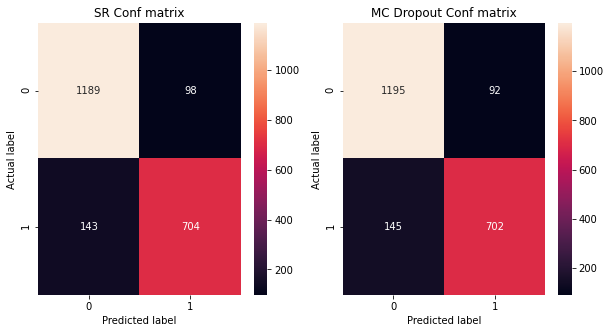

In [33]:
import seaborn as sns
plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)
plot_cm(y_true[bm_idx],y_pred[bm_idx],[0,1],'SR Conf matrix')

ax1 = plt.subplot(1,2,2)
plot_cm(y_true[bm_idx],mc_pred[bm_idx],[0,1],'MC Dropout Conf matrix')
plt.show()

In [34]:
fpr, tpr, _ = roc_curve(y_true[bm_idx], predictions[bm_idx,1],pos_label=1)
mcfpr, mctpr, _ = roc_curve(y_true[bm_idx], img_means[bm_idx,1],pos_label=1)

In [35]:
roc_auc = auc(fpr, tpr)
roc_auc

0.9395003527234932

In [36]:
mcroc_auc = auc(mcfpr, mctpr)
mcroc_auc

0.940177361664965

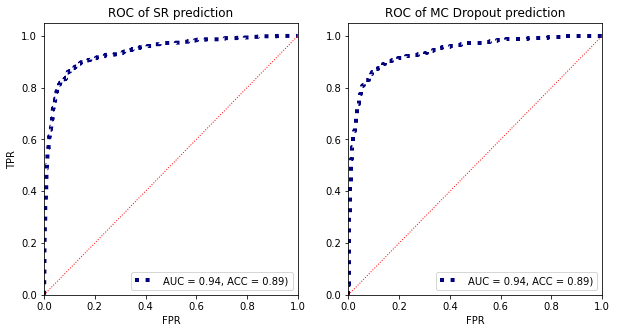

In [37]:
plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)
plt.plot(fpr, tpr,
         label='AUC = {0:0.2f}, ACC = {1:0.2f})'
               ''.format(roc_auc,acc),
         color='navy', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'r:', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC of SR prediction")
plt.legend(loc="lower right")

ax = plt.subplot(1,2,2)
plt.plot(mcfpr, mctpr,
         label='AUC = {0:0.2f}, ACC = {1:0.2f})'
               ''.format(mcroc_auc,mc_acc),
         color='navy', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'r:', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')

plt.title("ROC of MC Dropout prediction")
plt.legend(loc="lower right")


plt.show()

In [38]:
# c_pred = np.apply_along_axis(np.argmax,axis=1,arr=mc_predictions)

### Predictive variance

In [41]:
img_var = np.var(mc_predictions,axis=1)
img_var.shape

(6117, 2)

In [53]:
#indexing variance with mc_preds
pred_var=img_var[np.arange(6117),mc_pred]

In [55]:
pred_var.shape

(6117,)

In [56]:
idx=9
print("standard pred: {}".format(y_pred[idx]))
print("posterior mean: {}".format(mc_pred[idx]))
print("true label: {}".format(y_true[idx]))
print()
# print("variation ratio {}".format(variation_ratio[idx]))
print("pred var: {}".format(pred_var[idx]))
print()
print("class: {}; proba: {:.2f}; var: {:.2f} ".format(0, img_means[idx,0], img_var[idx,0]))
print("class: {}; proba: {:.2f}; var: {:.2f} ".format(1, img_means[idx,1], img_var[idx,1]))

standard pred: 1
posterior mean: 1
true label: 2

pred var: 0.0001027062359335428

class: 0; proba: 0.01; var: 0.00 
class: 1; proba: 0.99; var: 0.00 


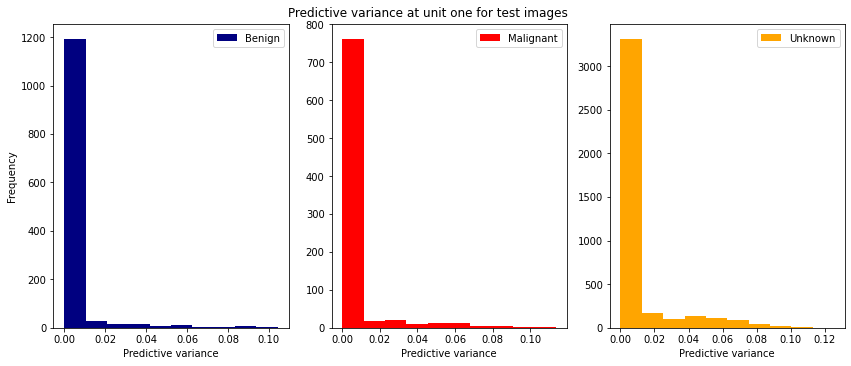

In [57]:
fig, (ax,ax1,ax2) =plt.subplots(1,3)
fig.set_size_inches(12,5)
h1 = ax.hist(img_var[b_idx,0],density=False, label="Benign",color='navy')
ax.set_xlabel('Predictive variance')
ax.set_ylabel('Frequency')
#ax.axes.get_yaxis().set_visible(False)
ax.legend()
h2 = ax1.hist(img_var[m_idx,0],density=False, label="Malignant", color='red')
ax1.set_xlabel('Predictive variance')
ax1.legend()
h3 = ax2.hist(img_var[u_idx,0],density=False, label="Unknown",color='orange')
ax2.set_xlabel('Predictive variance')
ax2.legend()

plt.suptitle('Predictive variance at unit one for test images',va ='baseline')
plt.tight_layout()
plt.show()

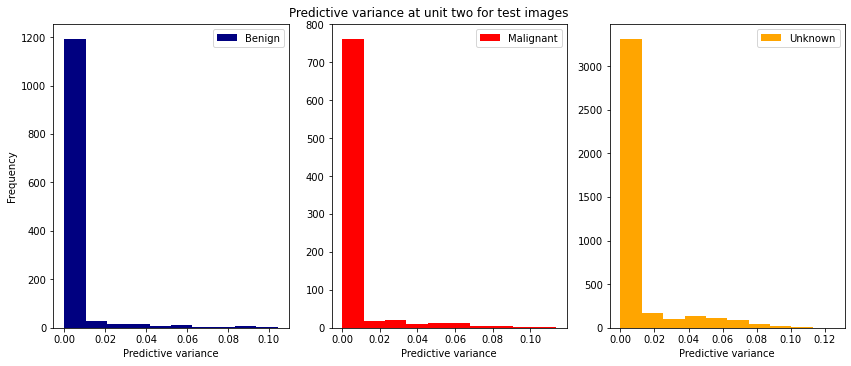

In [58]:
fig, (ax,ax1,ax2) =plt.subplots(1,3)
fig.set_size_inches(12,5)
h1 = ax.hist(img_var[b_idx,1],density=False, label="Benign",color='navy')
ax.set_xlabel('Predictive variance')
ax.set_ylabel('Frequency')
#ax.axes.get_yaxis().set_visible(False)
ax.legend()
h2 = ax1.hist(img_var[m_idx,1],density=False, label="Malignant", color='red')
ax1.set_xlabel('Predictive variance')
ax1.legend()
h3 = ax2.hist(img_var[u_idx,1],density=False, label="Unknown",color='orange')
ax2.set_xlabel('Predictive variance')
ax2.legend()

plt.suptitle('Predictive variance at unit two for test images',va ='baseline')
plt.tight_layout()
plt.show()

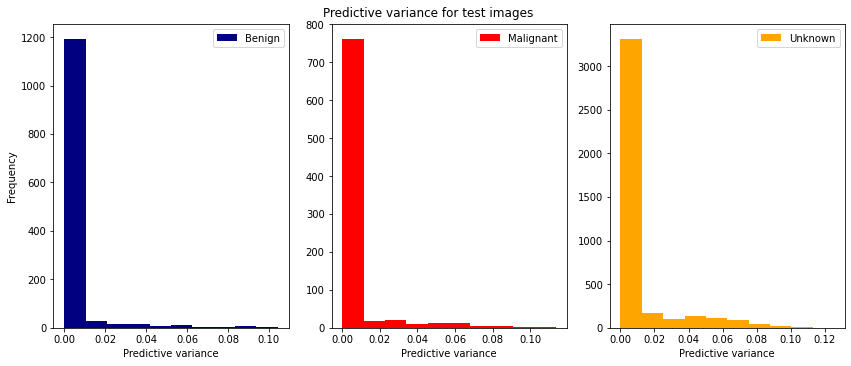

In [59]:
fig, (ax,ax1,ax2) =plt.subplots(1,3)
fig.set_size_inches(12,5)
h1 = ax.hist(pred_var[b_idx],density=False, label="Benign",color='navy')
ax.set_xlabel('Predictive variance')
ax.set_ylabel('Frequency')
#ax.axes.get_yaxis().set_visible(False)
ax.legend()
h2 = ax1.hist(pred_var[m_idx],density=False, label="Malignant", color='red')
ax1.set_xlabel('Predictive variance')
ax1.legend()
h3 = ax2.hist(pred_var[u_idx],density=False, label="Unknown",color='orange')
ax2.set_xlabel('Predictive variance')
ax2.legend()

plt.suptitle('Predictive variance for test images',va ='baseline')
plt.tight_layout()
plt.show()

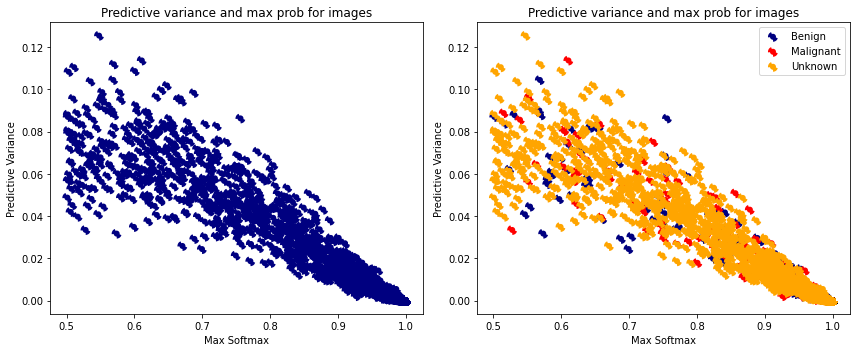

In [60]:
fig, (ax,ax1) =plt.subplots(1,2)
fig.set_size_inches(12,5)
ax.scatter(np.amax(img_means,axis=1),pred_var,color='navy', linestyle=':', linewidth=4)
ax.set_xlabel('Max Softmax')
ax.set_ylabel('Predictive Variance')
ax.set_title('Predictive variance and max prob for images')


ax1.scatter(np.amax(img_means[b_idx],axis=1),pred_var[b_idx],color='navy', linestyle=':', linewidth=4,label="Benign")
ax1.scatter(np.amax(img_means[m_idx],axis=1),pred_var[m_idx],color='red', linestyle=':', linewidth=4,label="Malignant")
ax1.scatter(np.amax(img_means[u_idx],axis=1),pred_var[u_idx],color='orange', linestyle=':', linewidth=4,label="Unknown")
ax1.set_xlabel('Max Softmax')
ax1.set_ylabel('Predictive Variance')
ax1.set_title('Predictive variance and max prob for images')
ax1.legend()
# plt.suptitle('Max Softmax',va ='baseline')
plt.tight_layout()
plt.show()

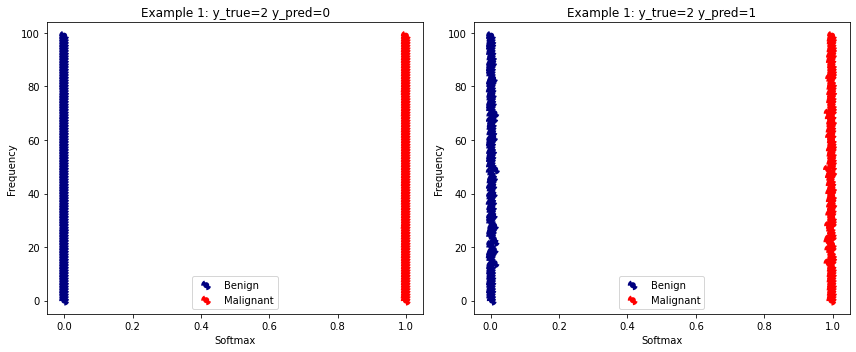

In [61]:
idx1=7
idx2=8
fig, (ax,ax1) =plt.subplots(1,2)
fig.set_size_inches(12,5)
ax.scatter(mc_predictions[u_idx[0],:,0],np.arange(T),color='navy', linestyle=':', linewidth=4, label="Benign")
ax.scatter(mc_predictions[u_idx[0],:,1],np.arange(T),color='red', linestyle=':', linewidth=4, label="Malignant")
ax.set_xlabel('Softmax')
ax.set_ylabel('Frequency')
ax.set_title('Example 1: y_true={} y_pred={}'.format(y_true[u_idx[0]],mc_pred[idx1]))
ax.legend()

ax1.scatter(mc_predictions[u_idx[1],:,0],np.arange(T),color='navy', linestyle=':', linewidth=4, label="Benign")
ax1.scatter(mc_predictions[u_idx[1],:,1],np.arange(T),color='red', linestyle=':', linewidth=4, label="Malignant")
ax1.set_xlabel('Softmax')
ax1.set_ylabel('Frequency')
ax1.set_title('Example 1: y_true={} y_pred={}'.format(y_true[u_idx[1]],mc_pred[idx2]))
ax1.legend()

plt.tight_layout()
plt.show()

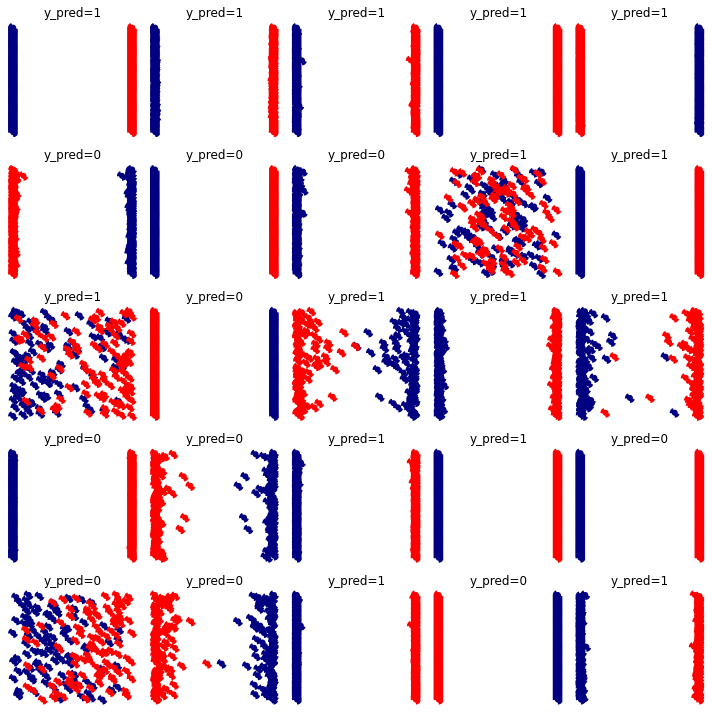

In [62]:
plt.figure(figsize=(10,10))
plt.ylabel('Frequency')
for n in range(25):
    ax = plt.subplot(5,5,n+1)
    plt.scatter(mc_predictions[u_idx[n],:,0],np.arange(T),color='navy', linestyle=':', linewidth=4, label="Benign")
    plt.scatter(mc_predictions[u_idx[n],:,1],np.arange(T),color='red', linestyle=':', linewidth=4, label="Malignant")
#     plt.xlabel('Softmax')
    plt.title('y_pred={}'.format(mc_pred[n]))
    plt.axis('off')
#     plt.legend()
plt.tight_layout()
plt.show()    